# CRT Placement - Met Éireann

## Package Imports

In [41]:
import os

import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

import random
import torchvision
from torchvision.utils import save_image
from torch.utils.data import Dataset
from osgeo import gdal as GD

from typing import Tuple, Dict, List
import pathlib

import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm



## Neural Network Layers

In [42]:
# In generator conv blocks, the channels go like "512->512->512->512->256->128->64->32->16"
factors = [1,1,1,1,1/2,1/4,1/8,1/16,1/32]

# Equalized learning rate applied on conv2d layers -- from ProGan paper
# in convolution operation: pixel * {weight * (1/norm)} <==> {pixel * (1/norm)} * weight 
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    # x-shape: Batch Size x Channels x H X W
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

# This ConvBlock will be used for both Generator and Discriminator, but inside, pixelnorm(after leakyReLU) is used only in Generator
# Be careful: the order is "conv2d-activation-norm", not "conv2d-norm-activation"
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

## Generator & Discriminator (Critic)

In [43]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3): #channels=13
        super(Generator, self).__init__()
        # starting structure of Generator should be opposite of ending structure of Discriminator
        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps): ## steps=0 : 4x4 output / steps=1 : 8x8 output / steps=2 : 16x16 output ...
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3): #channels=13
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            
            ## rgb_layers list : [(1024x1024 input'from_rgb' layer),(512x512 input'from_rgb' layer),(256x256 input'from_rgb' layer) ...]
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        ## this 'from-rgb' layer is for 4x4 resolution
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        ## ConvBlock for 4x4 resolution
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):     ## NxCxHxW -> N -> 1 -> Nx1xHxW
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):     ## steps=0 : 4x4 input / steps=1 : 8x8 input ...
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

## Utilities

In [44]:
def save_on_tensorboard(writer,loss_critic,loss_gen,real,fake,tensorboard_step):
    writer.add_scalar("Loss Critic",loss_critic,global_step=tensorboard_step)
    writer.add_scalar("Loss Generator", loss_gen, global_step=tensorboard_step)
    
    with torch.no_grad():
        img_grid_real = torchvision.utils.make_grid(real[:8],normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8],normalize=True)
        
        writer.add_image("Real",img_grid_real,global_step = tensorboard_step)
        writer.add_image("Fake",img_grid_fake,global_step = tensorboard_step)
        
def gradient_penalty(critic,real,fake,alpha,train_step,device="cpu"):    
    BATCH_SIZE,C,H,W = real.shape
    beta = torch.rand((BATCH_SIZE,1,1,1)).repeat(1,C,H,W).to(device)

    interpolated_images = real * beta + fake.detach() * (1-beta)
    interpolated_images.requires_grad_(True)
    
    ## Calculate critic scores
    mixed_scores = critic(interpolated_images,alpha,train_step)
    
    ## Take the gradient of the scores with respect to the image
    gradient = torch.autograd.grad(
        inputs = interpolated_images,
        outputs = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph = True,
        retain_graph = True
    )[0]
    
    gradient = gradient.view(gradient.shape[0],-1)
    gradient_norm = gradient.norm(2,dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

def save_checkpoint(model,optimizer,filename="my_checkpoint.pth"):
    print("Saving Checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer" : optimizer.state_dict()
    }
    torch.save(checkpoint,filename)
    
def load_checkpoint(checkpoint_file,model,optimizer,lr):
    print("Loading Checkpoint")
    checkpoint = torch.load(checkpoint_file,map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        
def generate_examples(gen,current_epoch,steps,n=16):
    gen.eval()
    alpha = 1.0
    
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1,Z_DIM,1,1).to(DEVICE)
            generated_img = gen(noise,alpha=alpha,steps=steps)
            save_image(generated_img*0.5+0.5, f"generated_images/step{steps}_epoch{current_epoch}_{i}.png")
            #torch.save(generated_img*0.5+0.5, f"generated_images/step{steps}_epoch{current_epoch}_{i}.pt")
    gen.train()

## SEN12MS Dataset

In [45]:

# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class SEN12MS(Dataset):
    """Custom dataset for SEN12MS data"""

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.tif")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        image = rasterio.open(str(image_path)).read([2,3,4])
        image_norm = cv2.normalize(image.astype(np.float32), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        #norm_image = (image - image.min()) / (image.max() - image.min())
        return np.transpose(image_norm,(1,2,0))
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

## Training Function

In [46]:
def get_loader(img_size):
    transform = transforms.Compose(
    [
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)],[0.5 for _ in range(IMG_CHANNELS)])
    ])

    transform_sen = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size,img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)],[0.5 for _ in range(IMG_CHANNELS)])
    ])
    
    batch_size = BATCH_SIZES[int(log2(img_size/4))]
    dataset = datasets.ImageFolder(root=DATASET,transform=transform)
    #dataset = SEN12MS(targ_dir=DATASET, transform=transform_sen)

    print("input shape:", dataset[0][0].shape)

    loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True) #batch_size
    
    return loader,dataset

def train_fn(gen,critic,loader,dataset,step,alpha,opt_gen,opt_critic,tensorboard_step,writer,scaler_gen,scaler_critic):
    #loop = tqdm(loader,leave=True)
    i = 0
    
    #for batch_idx, (real, _) in enumerate(loop):#batch_idx,(real,_) in enumerate(loop):
    for batch_idx, (real, _) in enumerate(loader):
        i += 1
        if i%2 == 0:
            continue
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size,Z_DIM,1,1).to(DEVICE)
        
        ## Train Critic
        ## Wasserstein Loss : Maximize "E[Critic(real)] - E[Critic(fake)]"   ==   Minimize "-(E[Critic(real)] - E[Critic(fake)])"
        with torch.cuda.amp.autocast():
            fake = gen(noise,alpha,step).to(DEVICE)
            critic_real = critic(real,alpha,step)
            critic_fake = critic(fake.detach(),alpha,step)
            gp = gradient_penalty(critic,real,fake,alpha,step,device=DEVICE)
            loss_critic = -1 * (torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp + 0.001 * torch.mean(critic_real**2)
        
        critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()
        
        ## Train Generator
        ## Maximize "E[Critic(fake)]"   ==   Minimize "- E[Critic(fake)]"
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake,alpha,step)
            loss_gen = -1 * torch.mean(gen_fake)
            
        gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()
    
        alpha += (cur_batch_size/len(dataset)) * (1/PROGRESSIVE_EPOCHS[step]) * 2
        alpha = min(alpha,1)
        
        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE,alpha,step) * 0.5 + 0.5
                #save_on_tensorboard(writer,loss_critic.item(),loss_gen.item(),real.detach(),fixed_fakes.detach(),tensorboard_step)
                tensorboard_step += 1
    
    return tensorboard_step,alpha

## Config & Hyperparameters

In [47]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

START_TRAIN_IMG_SIZE = 4
DATASET = os.path.join(os.path.dirname(os.getcwd()), "input/Overfit") #"input/ROIs1158_spring/train/"
DATASET = os.path.join(os.path.dirname(os.getcwd()), "input/Face_Overfit") #"input/ROIs1158_spring/train/"

print(os.path.dirname(os.getcwd()))

CHECKPOINT_GEN = "CHECKPOINT_GEN_OF.pt"
CHECKPOINT_CRITIC = "CHECKPOINT_CRITIC_OF.pt"
SAVE_MODEL = False
LOAD_MODEL = False

LR = 1e-3
BATCH_SIZES = [1,1,1,1,1,1,1] #[256,256,128,64,32,16,8] ## modifiable/ Batch_sizes for each step
IMAGE_SIZE = 256 ## 1024 for paper
IMG_CHANNELS = 3 #13
Z_DIM = 256 ## 512 for paper
IN_CHANNELS = 256 ## 512 for paper
LAMBDA_GP = 10
NUM_STEPS = int(log2(IMAGE_SIZE/4)) + 1

PROGRESSIVE_EPOCHS = [500] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8,Z_DIM,1,1).to(DEVICE)
# NUM_WORKERS = 4
NUM_WORKERS = 0 # have to set to zero otherwise get an error
torch.backends.cudnn.benchmarks = True


print(DEVICE)
print(DATASET)

c:\Users\Paddy\CRT\Github
cuda
c:\Users\Paddy\CRT\Github\input/Face_Overfit


## Training

In [48]:
def train_progan():
    ## build model
    gen = Generator(Z_DIM,IN_CHANNELS,IMG_CHANNELS).to(DEVICE)
    critic = Discriminator(IN_CHANNELS,IMG_CHANNELS).to(DEVICE)

    ## initialize optimizer,scalers (for FP16 training)
    opt_gen = optim.Adam(gen.parameters(),lr=LR,betas=(0.0,0.99))
    opt_critic = optim.Adam(critic.parameters(),lr=LR,betas=(0.0,0.99))
    scaler_gen = torch.cuda.amp.GradScaler()
    scaler_critic = torch.cuda.amp.GradScaler()

    ## tensorboard writer
    writer = SummaryWriter(f"runs/PG_GAN")
    tensorboard_step = 0

    ## if checkpoint files exist, load model
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN,gen,opt_gen,LR)
        load_checkpoint(CHECKPOINT_CRITIC,critic,opt_critic,LR)
        
    gen.train()
    critic.train()

    step = 6# int(log2(START_TRAIN_IMG_SIZE/4)) ## starts from 0

    global_epoch = 0
    generate_examples_at = [1,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]#[1,4,8,12,16,20,24,28,32]

    for num_epochs in PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-4
        loader,dataset = get_loader(4*2**step)
        print(f"Image size:{4*2**step} | Current step:{step}")
        
        for epoch in tqdm(range(num_epochs)):
            #print(f"Epoch [{epoch+1}/{num_epochs}] Global Epoch:{global_epoch}")
            tensorboard_step,alpha = train_fn(gen,critic,loader,dataset,step,alpha,opt_gen,opt_critic,tensorboard_step,writer,scaler_gen,scaler_critic)
            global_epoch += 1
            if global_epoch in generate_examples_at:
                generate_examples(gen,global_epoch,step,n=3)
            
            if SAVE_MODEL and (epoch+1)%8==0:
                save_checkpoint(gen,opt_gen,filename=CHECKPOINT_GEN)
                save_checkpoint(critic,opt_critic,filename=CHECKPOINT_CRITIC)
                
        step += 1 ## Progressive Growing

    if SAVE_MODEL:
        save_checkpoint(gen,opt_gen,filename=CHECKPOINT_GEN)
        save_checkpoint(critic,opt_critic,filename=CHECKPOINT_CRITIC)

    print("Training finished")
    return gen, critic

gen, critic = train_progan()


input shape: torch.Size([3, 256, 256])
Image size:256 | Current step:6


100%|██████████| 500/500 [01:07<00:00,  7.37it/s]

Training finished


## Loading Model

In [49]:
def load_progan():
    ## build model
    gen = Generator(Z_DIM,IN_CHANNELS,IMG_CHANNELS).to(DEVICE)
    critic = Discriminator(IN_CHANNELS,IMG_CHANNELS).to(DEVICE)

    ## initialize optimizer,scalers (for FP16 training)
    opt_gen = optim.Adam(gen.parameters(),lr=LR,betas=(0.0,0.99))
    opt_critic = optim.Adam(critic.parameters(),lr=LR,betas=(0.0,0.99))
    scaler_gen = torch.cuda.amp.GradScaler()
    scaler_critic = torch.cuda.amp.GradScaler()

    ## if checkpoint files exist, load model
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN,gen,opt_gen,LR)
        load_checkpoint(CHECKPOINT_CRITIC,critic,opt_critic,LR)
        
    gen.train()
    critic.train()

    print("Models loaded")
    return gen, critic

#gen, critic = load_progan()


## Plotting Samples

(3, 256, 256)


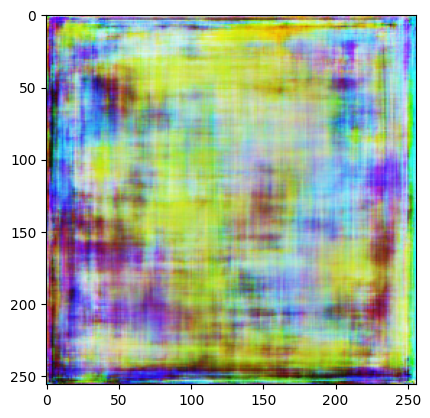

In [51]:
def plot_sample(gen,steps=6,n=16):
    gen.eval()
    with torch.no_grad():
        noise = torch.randn(1,Z_DIM,1,1).to(DEVICE)
        generated_img = gen(noise,alpha=1,steps=steps)
        img = (generated_img*0.5+0.5)[0].detach().cpu().numpy()
        #print(img)
        print(img.shape)
        show(np.transpose(img,(0,1,2)))
    gen.train()

def plot_sample_bands(gen,steps=6,n=16):
    gen.eval()
    with torch.no_grad():
        noise = torch.randn(1,Z_DIM,1,1).to(DEVICE)
        generated_img = gen(noise,alpha=0.5,steps=steps)
        print((generated_img*0.5+0.5)[0].shape)
        img = generated_img.detach().cpu().numpy()
        print(img.shape)
        for i in range(img.shape[1]):
            band = img[0][i]
            img_out = np.dstack(band)
            print(img_out.shape)
            show(np.transpose(img_out,(2,1,0)))
    gen.train()

plot_sample(gen, steps=6)
